In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spark-big-data/Region_info.csv
/kaggle/input/spark-big-data/Medical_info.csv


In [2]:
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

     |████████████████████████████████| 212.4 MB 61 kB/s s eta 0:00:01    |██████▍                         | 42.7 MB 27.7 MB/s eta 0:00:07
     |████████████████████████████████| 198 kB 40.0 MB/s eta 0:00:01
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=b04f86f813f7e2bf3c2791d0290e0b8eafeb28ecc2714a65f2bfaec2b3bbd825
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark


In [3]:
# creating the spark session
spark = SparkSession.builder.appName("Session1").getOrCreate()

In [4]:
#1.1

# Loading the dataframw
df1 = spark.read.csv('/kaggle/input/spark-big-data/Medical_info.csv', header = True, inferSchema = True)
df1.show(5)

# Number of rows
print("Number of Rows: ", df1.count())
# Number of columns
print("Number of columns: ", len(df1.columns))

+--------+---+------+---+---+-----------+--------+--------+-------+------------+----+
|      id|age|   BMI|PSA| TG|Cholesterol|LDLChole|HDLChole|Glucose|Testosterone|BP_1|
+--------+---+------+---+---+-----------+--------+--------+-------+------------+----+
|19782173| 59|28.378|.34|204|        196|     132|      49|     92|         7.7|   1|
|32613511| 59|24.968|  1|147|        181|     129|      34|     96|        4.09|   1|
|32723850| 48|31.307|.62|155|        185|     127|      41|    139|         4.5|   1|
|22913531| 47|27.837|.38|488|        254|     158|      55|    250|         5.3|   2|
|32628551| 55|22.662|.49| 87|        175|     120|      44|     99|         6.9|   1|
+--------+---+------+---+---+-----------+--------+--------+-------+------------+----+
only showing top 5 rows

Number of Rows:  6967
Number of columns:  11


In [5]:
df1.printSchema()

root
 |-- id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- PSA: string (nullable = true)
 |-- TG: integer (nullable = true)
 |-- Cholesterol: string (nullable = true)
 |-- LDLChole: integer (nullable = true)
 |-- HDLChole: integer (nullable = true)
 |-- Glucose: string (nullable = true)
 |-- Testosterone: double (nullable = true)
 |-- BP_1: integer (nullable = true)



In [6]:
df1 = df1.withColumn('PSA',df1['PSA'].cast("float").alias('PSA'))
df1 = df1.withColumn('Cholesterol',df1['Cholesterol'].cast("float").alias('Cholesterol'))
df1 = df1.withColumn('Glucose',df1['Glucose'].cast("float").alias('Glucose'))
df1.printSchema()

root
 |-- id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- PSA: float (nullable = true)
 |-- TG: integer (nullable = true)
 |-- Cholesterol: float (nullable = true)
 |-- LDLChole: integer (nullable = true)
 |-- HDLChole: integer (nullable = true)
 |-- Glucose: float (nullable = true)
 |-- Testosterone: double (nullable = true)
 |-- BP_1: integer (nullable = true)



In [7]:
#1.2

# Creating second dataframe by dropping all rows containing Null values
df2 = df1.na.drop("any")

# Number of rows dropped
print("Number of rows dropped: ", df1.count() - df2.count())

Number of rows dropped:  58


+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|              6909|
|   mean|53.340715009408015|
| stddev| 8.712714893790364|
|    min|                21|
|    max|                90|
+-------+------------------+



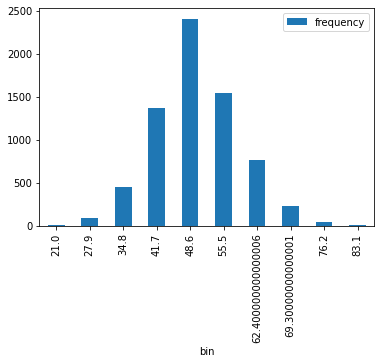

In [8]:
#1.3
import matplotlib.pyplot as plt

# Summary statistics for "age"
df2.select(col("age")).describe().show()

# Histogram for "age"
gre_histogram = df2.select(col('age')).rdd.flatMap(lambda x: x).histogram(10)

# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(list(zip(*gre_histogram)), 
    columns=['bin', 'frequency']
).set_index(
    'bin').plot(kind='bar');

+-------+------------------+
|summary|               BMI|
+-------+------------------+
|  count|              6909|
|   mean|24.755393110435616|
| stddev|2.8347164500863715|
|    min|               0.0|
|    25%|            22.975|
|    50%|            24.701|
|    75%|            26.435|
|    max|            43.261|
+-------+------------------+



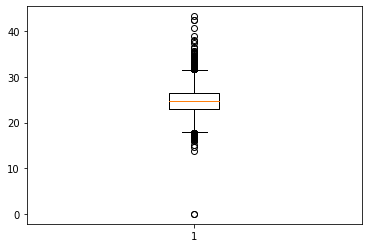

In [9]:
# 1.4

# Quartile information of BMI
df2.select(col("BMI")).summary().show()

# Making Box-Plot
bpdf = df2.select(col("BMI")).toPandas()
plt.boxplot(bpdf)
plt.show()

In [10]:
# 1.5

# Getting number of rows which have age greater than 50 and BP_1 equal to 1
df2.filter("age > 50" and "BP_1 == '1'").count()

3868

In [11]:
# 1.6
from pyspark.ml.classification import LogisticRegression
df2.printSchema()

from pyspark.ml.feature import StringIndexer, VectorAssembler

stages = []
label_stringIdx = StringIndexer(inputCol = 'BP_1', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'BMI', 'PSA', 'TG','Cholesterol', 'LDLChole', 'HDLChole','Glucose', 'Testosterone']
cols = ['age', 'BMI','PSA', 'TG', 'Cholesterol', 'LDLChole', 'HDLChole', 'Glucose', 'Testosterone', "BP_1"]
assemblerInputs = numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

root
 |-- id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- PSA: float (nullable = true)
 |-- TG: integer (nullable = true)
 |-- Cholesterol: float (nullable = true)
 |-- LDLChole: integer (nullable = true)
 |-- HDLChole: integer (nullable = true)
 |-- Glucose: float (nullable = true)
 |-- Testosterone: double (nullable = true)
 |-- BP_1: integer (nullable = true)



In [12]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df2)
df2 = pipelineModel.transform(df2)
selectedCols = ['label', 'features'] + cols
df2 = df2.select(selectedCols)
df2.printSchema()



root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- PSA: float (nullable = true)
 |-- TG: integer (nullable = true)
 |-- Cholesterol: float (nullable = true)
 |-- LDLChole: integer (nullable = true)
 |-- HDLChole: integer (nullable = true)
 |-- Glucose: float (nullable = true)
 |-- Testosterone: double (nullable = true)
 |-- BP_1: integer (nullable = true)



In [13]:
train, test = df2.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 4882
Test Dataset Count: 2027


In [14]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

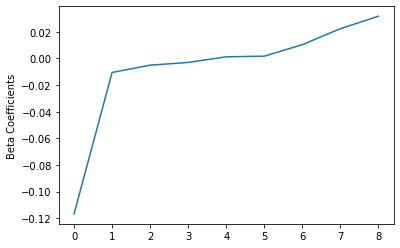

In [15]:
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

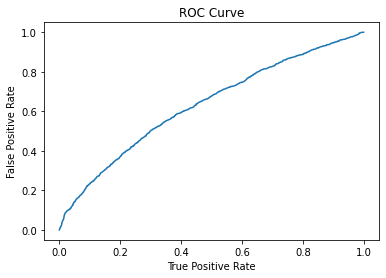

Training set areaUnderROC: 0.6319334100048696


In [16]:
trainingSummary = lrModel.summary
lrROC = trainingSummary.roc.toPandas()

plt.plot(lrROC['FPR'],lrROC['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

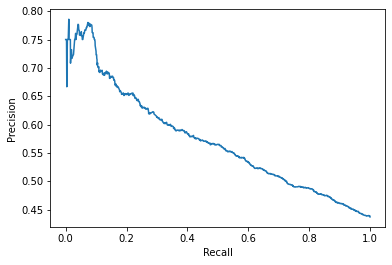

In [17]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [18]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

# Make prediction
predictionAndTarget = lrModel.transform(df2).select("label", "prediction")

# Create both evaluators
metrics_binary = BinaryClassificationMetrics(predictionAndTarget.rdd.map(tuple))
metrics_multi = MulticlassMetrics(predictionAndTarget.rdd.map(tuple))

acc = metrics_multi.accuracy
f1 = metrics_multi.fMeasure(1.0)
precision = metrics_multi.precision(1.0)
recall = metrics_multi.recall(1.0)
auc = metrics_binary.areaUnderROC

print("Evaluation metrices on Test Data: ")
print("Accuracy: ", acc)
print("F1-Score: ", f1)
print("Precision: ", precision)
print("Recall: ", recall)
print("AUC: ", auc)

Evaluation metrices on Test Data: 
Accuracy:  0.6107975104935591
F1-Score:  0.47877495638689666
Precision:  0.40611640907596186
Recall:  0.5830972615675165
AUC:  0.6030702337893938


In [19]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
rfPreds = rfModel.transform(test)

In [20]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

# Make prediction
predictionAndTarget = rfModel.transform(df2).select("label", "prediction")

# Create both evaluators
metrics_binary = BinaryClassificationMetrics(predictionAndTarget.rdd.map(tuple))
metrics_multi = MulticlassMetrics(predictionAndTarget.rdd.map(tuple))

acc = metrics_multi.accuracy
f1 = metrics_multi.fMeasure(1.0)
precision = metrics_multi.precision(1.0)
recall = metrics_multi.recall(1.0)
auc = metrics_binary.areaUnderROC

print("Test Accuracy: ", acc)
print("F1-Score: ", f1)
print("Precision: ", precision)
print("Recall: ", recall)
print("AUC: ", auc)

Test Accuracy:  0.6569691706469822
F1-Score:  0.5405195812330361
Precision:  0.45840184149950675
Recall:  0.6584789796882381
AUC:  0.6573905749860223


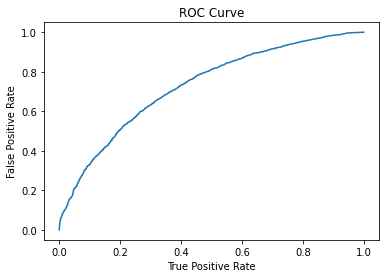

Training set areaUnderROC: 0.7283439715798111


In [21]:
trainingSummary = rfModel.summary
rfROC = trainingSummary.roc.toPandas()

plt.plot(rfROC['FPR'],ROC['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [22]:
# 2.1

# Loading the dataframw
df3 = spark.read.csv('/kaggle/input/spark-big-data/Region_info.csv', header = True, inferSchema = True)
df3.show(5)

# Number of rows
print("Number of Rows: ", df3.count())
# Number of columns
print("Number of columns: ", len(df3.columns))

+-----------+---------+---+------------------+--------+-------+----------+----+---------------+--------------------+
| population|fertility|HIV|               CO2|BMI_male|    GDP|BMI_female|life|child_mortality|              Region|
+-----------+---------+---+------------------+--------+-------+----------+----+---------------+--------------------+
|3.4811059E7|     2.73|0.1| 3.328944661018629| 24.5962|12314.0|  129.9049|75.3|           29.5|Middle East & Nor...|
|1.9842251E7|     6.43|2.0|1.4743533878509398|22.25083| 7103.0|  130.1247|58.3|          192.0|  Sub-Saharan Africa|
| 4.038186E7|     2.24|0.5|  4.78516998252535| 27.5017|14646.0|  118.8915|75.5|           15.4|             America|
|  2975029.0|      1.4|0.1|   1.8041062172001|25.35542| 7383.0|  132.8108|72.5|           20.0|Europe & Central ...|
|2.1370348E7|     1.96|0.1|  18.0163132681972|27.56373|41312.0|  117.3755|81.5|            5.2| East Asia & Pacific|
+-----------+---------+---+------------------+--------+-------+-

In [23]:
# 2.2
df4 = df3.drop("region")
df4.show(5)

+-----------+---------+---+------------------+--------+-------+----------+----+---------------+
| population|fertility|HIV|               CO2|BMI_male|    GDP|BMI_female|life|child_mortality|
+-----------+---------+---+------------------+--------+-------+----------+----+---------------+
|3.4811059E7|     2.73|0.1| 3.328944661018629| 24.5962|12314.0|  129.9049|75.3|           29.5|
|1.9842251E7|     6.43|2.0|1.4743533878509398|22.25083| 7103.0|  130.1247|58.3|          192.0|
| 4.038186E7|     2.24|0.5|  4.78516998252535| 27.5017|14646.0|  118.8915|75.5|           15.4|
|  2975029.0|      1.4|0.1|   1.8041062172001|25.35542| 7383.0|  132.8108|72.5|           20.0|
|2.1370348E7|     1.96|0.1|  18.0163132681972|27.56373|41312.0|  117.3755|81.5|            5.2|
+-----------+---------+---+------------------+--------+-------+----------+----+---------------+
only showing top 5 rows



In [24]:
df4.printSchema()

root
 |-- population: double (nullable = true)
 |-- fertility: double (nullable = true)
 |-- HIV: double (nullable = true)
 |-- CO2: double (nullable = true)
 |-- BMI_male: double (nullable = true)
 |-- GDP: double (nullable = true)
 |-- BMI_female: double (nullable = true)
 |-- life: double (nullable = true)
 |-- child_mortality: double (nullable = true)



[]

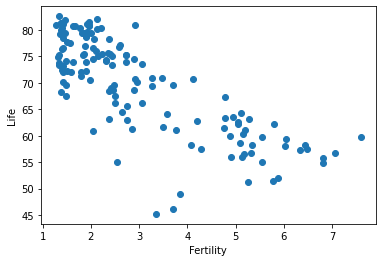

In [27]:
#2.3
x = df4.select(col("fertility")).collect()
y = df4.select(col("life")).collect()

plt.scatter(x, y)
plt.xlabel("Fertility")
plt.ylabel("Life")
plt.plot()

In [24]:
# 2.4
df4.createOrReplaceTempView("RegionTable1")
filter_rows = spark.sql("SELECT fertility, life from RegionTable1 where fertility > 1.0 and life > 70")
print("Number of filteres rows: ", filter_rows.count())
filter_rows.show(filter_rows.count())

Number of filteres rows:  78
+---------+----+
|fertility|life|
+---------+----+
|     2.73|75.3|
|     2.24|75.5|
|      1.4|72.5|
|     1.96|81.5|
|     1.41|80.4|
|     1.99|70.6|
|     1.89|72.2|
|     1.83|75.3|
|     1.42|70.1|
|     1.82|79.4|
|     2.91|70.7|
|     3.48|70.9|
|      1.9|73.9|
|     1.43|73.2|
|     1.68|80.7|
|     1.89|78.9|
|     2.43|75.1|
|     1.91|79.7|
|     1.43|76.5|
|      1.5|77.8|
|     1.89|78.7|
|     2.73|74.0|
|     2.95|70.1|
|     2.32|74.1|
|     1.62|74.0|
|     1.85|79.4|
|     1.97|81.0|
|     1.79|72.1|
|     1.37|80.0|
|     1.46|79.5|
|     4.12|70.8|
|     3.27|70.9|
|     1.33|73.8|
|     2.12|82.0|
|     1.88|76.9|
|      2.0|79.4|
|     2.92|80.9|
|     1.39|81.4|
|     2.39|75.5|
|     1.34|82.6|
|      1.5|72.3|
|     1.57|77.6|
|     1.42|72.0|
|     1.63|80.7|
|     2.05|74.5|
|     2.38|78.2|
|     1.38|81.4|
|     1.58|72.1|
|     2.35|75.7|
|     2.44|73.3|
|     1.77|80.3|
|     2.12|80.2|
|     2.72|75.2|
|     1.96|80.7|
| 

In [25]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['fertility'], outputCol = 'features')
lm_data = vectorAssembler.transform(df4)
lm_data = lm_data.select(['features', 'life'])
lm_data.show(5)

+--------+----+
|features|life|
+--------+----+
|  [2.73]|75.3|
|  [6.43]|58.3|
|  [2.24]|75.5|
|   [1.4]|72.5|
|  [1.96]|81.5|
+--------+----+
only showing top 5 rows



In [26]:
# Train test split
splits = lm_data.randomSplit([0.7, 0.3])
lr_train = splits[0]
lr_test = splits[1]

In [27]:
# 2.5
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='life', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(lr_train)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

Coefficients: [-4.30507141508356]
Intercept: 82.99713326553409
RMSE: 5.294194
r2: 0.642743


In [28]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['population', 'fertility', 'HIV', 'CO2', 'BMI_male', 'GDP', 'BMI_female','child_mortality'],
                                  outputCol = 'features')
lasso_data = vectorAssembler.transform(df4)
lasso_data = lasso_data.select(['features', 'life'])
lasso_data.show(5)

+--------------------+----+
|            features|life|
+--------------------+----+
|[3.4811059E7,2.73...|75.3|
|[1.9842251E7,6.43...|58.3|
|[4.038186E7,2.24,...|75.5|
|[2975029.0,1.4,0....|72.5|
|[2.1370348E7,1.96...|81.5|
+--------------------+----+
only showing top 5 rows



In [29]:
# Making train-test split
splits = lasso_data.randomSplit([0.7, 0.3])
lasso_train = splits[0]
lasso_test = splits[1]

In [30]:
# 2.6
from pyspark.ml.regression import LinearRegression

# Linear Regression with elasticNetParam = 1 is Lasso Regression model
lasso = LinearRegression(featuresCol = 'features', labelCol='life', maxIter=10, regParam=0.3, elasticNetParam=1)
lasso_model = lasso.fit(lasso_train)
print("Coefficients: " + str(lasso_model.coefficients))
print("Intercept: " + str(lasso_model.intercept))

trainingSummary = lasso_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

Coefficients: [0.0,-0.5732455424313143,-0.5410284225288226,0.0,0.19416431173801324,0.00011752113899526318,-0.2518894462696331,-0.080993098705302]
Intercept: 101.09134429967705
RMSE: 3.126634
r2: 0.883974
